In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [213]:
#load data_tanque.csv
data_tanque = pd.read_csv('../datos estanque/datos sin falla/referencia_fija_t_continuo.csv')

data_tanque.head()

,tiempo,referencia,hc,f_pid
0,0,25,0.000001,0.01
1,1,25,6.230122,99.99
2,2,25,9.322159,99.99
3,3,25,11.255697,99.99
4,4,25,13.107113,99.99


In [214]:
#sample data linearly by 2 rows till 20000 rows
df = data_tanque.copy()
sampling_time = 1
df = df[::sampling_time]

#create a new column with the previous value of hc
df['hc_prev'] = df['hc'].shift(1)

#crate a column with the previous value of hc_prev...
df['hc_prev_prev'] = df['hc_prev'].shift(1)
df['hc_prev_3'] = df['hc_prev_prev'].shift(1)
df['hc_prev_4'] = df['hc_prev_3'].shift(1)

#same with frequency
df['freq_prev'] = df['f_pid'].shift(1)
df['freq_prev_prev'] = df['freq_prev'].shift(1)
df['freq_prev_3'] = df['freq_prev_prev'].shift(1)
df['freq_prev_4'] = df['freq_prev_3'].shift(1)


In [215]:
df.head()

,tiempo,referencia,hc,f_pid,hc_prev,hc_prev_prev,hc_prev_3,hc_prev_4,freq_prev,freq_prev_prev,freq_prev_3,freq_prev_4
0,0,25,0.000001,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,25,6.230122,99.99,0.000001,NaN,NaN,NaN,0.01,NaN,NaN,NaN
2,2,25,9.322159,99.99,6.230122,0.000001,NaN,NaN,99.99,0.01,NaN,NaN
3,3,25,11.255697,99.99,9.322159,6.230122,0.000001,NaN,99.99,99.99,0.01,NaN
4,4,25,13.107113,99.99,11.255697,9.322159,6.230122,0.000001,99.99,99.99,99.99,0.01


Text(0.5, 1.0, 'referencia y hc en funcion del tiempo')

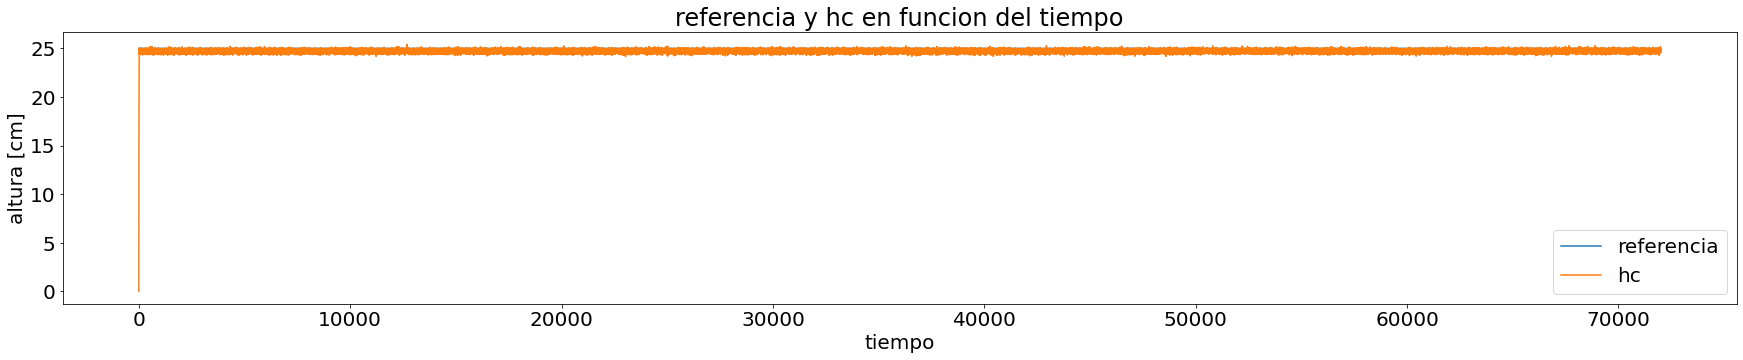

In [216]:
#graficar los referencia y hc en funcion del tiempo
plt.figure(figsize=(30,5))
plt.plot(df['tiempo'], df['referencia'], label='referencia')
plt.plot(df['tiempo'], df['hc'], label='hc')
plt.legend()
plt.xlabel('tiempo')
plt.ylabel('altura [cm]')
plt.title('referencia y hc en funcion del tiempo')

# RED MLP

In [217]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.cuda.is_available() 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [218]:
#train set: 12 hours
step = int(12*3600/sampling_time)

X_train = torch.from_numpy(np.vstack(((df['hc_prev'].to_numpy()[4:step],
                                     df['hc_prev_prev'].to_numpy()[4:step],
                                     
                                     df['f_pid'].to_numpy()[4:step],
                                     df['freq_prev'].to_numpy()[4:step],
                                    ))).T).float()


y_train = torch.from_numpy(((df['hc'].to_numpy()[4:step]))).float()


#create validation data since 12 hours to the end:

X_valid = torch.from_numpy(np.vstack(((df['hc_prev'].to_numpy()[step:],
                                     df['hc_prev_prev'].to_numpy()[step:],
                                     df['f_pid'].to_numpy()[step:],
                                     df['freq_prev'].to_numpy()[step:],
                                     ))).T).float()
                                      
y_valid = torch.from_numpy(((df['hc'].to_numpy()[step:]))).float()



In [219]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_valid = X_valid.to(device)
y_valid = y_valid.to(device)

In [220]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(4, 200),
            nn.ReLU(),
            nn.Linear(200, 300),
            nn.ReLU(),
            nn.Linear(300, 150),
            nn.ReLU(),
            nn.Linear(150, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.ReLU(),
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x
    

In [221]:
model = MLP()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

loss_curve_train = [np.inf]
loss_curve_valid = [np.inf]

#train model with early stopping
epochs = 1000
for epoch in range(epochs):
    model.train()
    y_pred = model(X_train)
    loss = loss_fn(y_pred.squeeze(), y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #validation
    model.eval()
    y_pred_val = model(X_valid)
    loss_val = loss_fn(y_pred_val.squeeze(), y_valid)

    # save best model
    if loss.item() < min(loss_curve_train) and loss_val.item() > min(loss_curve_valid):
        print('saving model...')
        torch.save(model.state_dict(), '../modelos torch/model_tanque_referencia_fija_5s.pt')
        print('Model saved')
    
    loss_curve_train.append(loss.item())
    loss_curve_valid.append(loss_val.item())

    print('Epoch: {}, Loss validation: {:.4f}, Loss train: {:.4f}'.format(epoch, loss_val.item(), loss.item() ))


Epoch: 0, Loss validation: 573.5947, Loss train: 598.6270
Epoch: 1, Loss validation: 546.7095, Loss train: 573.0347
Epoch: 2, Loss validation: 514.5151, Loss train: 546.1323
Epoch: 3, Loss validation: 473.1879, Loss train: 513.9236
Epoch: 4, Loss validation: 422.5131, Loss train: 472.5867
Epoch: 5, Loss validation: 361.5360, Loss train: 421.9028
Epoch: 6, Loss validation: 290.8651, Loss train: 360.9265
Epoch: 7, Loss validation: 213.5372, Loss train: 290.2825
Epoch: 8, Loss validation: 134.1732, Loss train: 213.0290
Epoch: 9, Loss validation: 64.7341, Loss train: 133.8236
Epoch: 10, Loss validation: 23.9331, Loss train: 64.6846
saving model...
Model saved
Epoch: 11, Loss validation: 34.1140, Loss train: 24.3937
Epoch: 12, Loss validation: 87.4830, Loss train: 35.3299
Epoch: 13, Loss validation: 121.6408, Loss train: 89.4634
Epoch: 14, Loss validation: 112.0803, Loss train: 123.9577
Epoch: 15, Loss validation: 78.3747, Loss train: 114.2791
Epoch: 16, Loss validation: 44.5508, Loss train

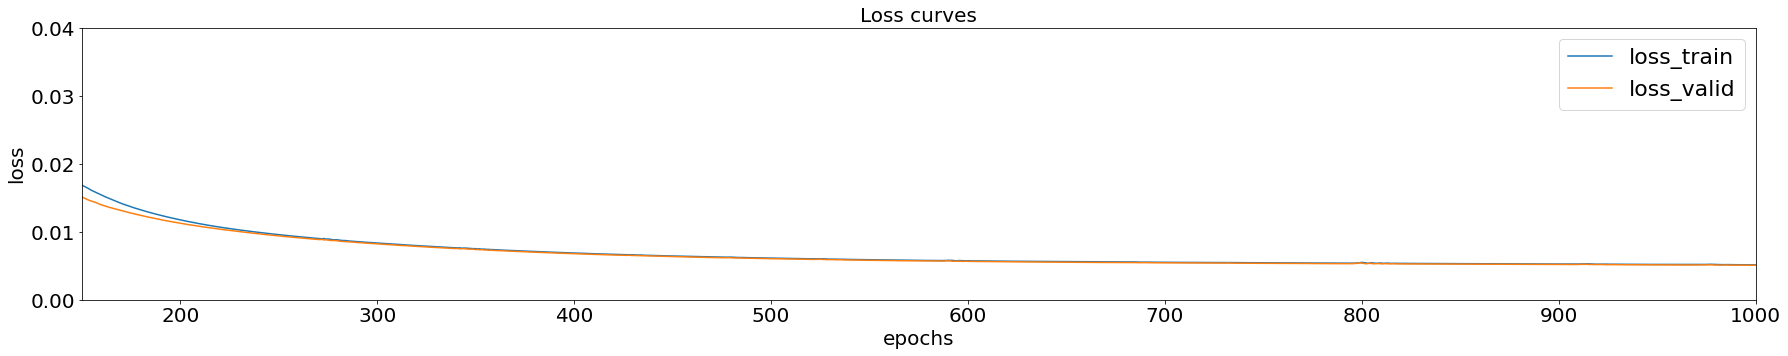

In [222]:
#plot loss curves (lmao what a noisy curves lol)


plt.figure(figsize=(30,5))
plt.plot(loss_curve_train[:], label='loss_train')
plt.plot(loss_curve_valid[:], label='loss_valid')
plt.xlabel('epochs')
plt.ylabel('loss')

plt.xlim(150, 1000)
plt.ylim(0, 0.04)
#increment font size and legend size
plt.legend(fontsize=20)
plt.title('Loss curves', fontsize=20)
plt.rcParams.update({'font.size': 22})

plt.legend()

In [223]:
#load model
model = MLP()
model.load_state_dict(torch.load('../modelos torch/model_tanque_referencia_fija_5s.pt'))
model.to(device)


MLP(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=150, bias=True)
    (5): ReLU()
    (6): Linear(in_features=150, out_features=50, bias=True)
    (7): ReLU()
    (8): Linear(in_features=50, out_features=10, bias=True)
    (9): ReLU()
    (10): Linear(in_features=10, out_features=1, bias=True)
    (11): ReLU()
  )
)

In [225]:
# test on another set... same as previous
data_tanque = pd.read_csv('../datos estanque/datos sin falla/referencia_fija_t_continuo.csv')
data_tanque.head()
df = data_tanque.copy()
sampling_time = 1
df = df[::sampling_time]
#create a new column with the previous value of hc
df['hc_prev'] = df['hc'].shift(1)
#crate a column with the previous value of hc_prev...
df['hc_prev_prev'] = df['hc_prev'].shift(1)
df['hc_prev_3'] = df['hc_prev_prev'].shift(1)
df['hc_prev_4'] = df['hc_prev_3'].shift(1)
#same with frequency
df['freq_prev'] = df['f_pid'].shift(1)
df['freq_prev_prev'] = df['freq_prev'].shift(1)
df['freq_prev_3'] = df['freq_prev_prev'].shift(1)
df['freq_prev_4'] = df['freq_prev_3'].shift(1)


#DEfine X_test and y_test
step = 0
X_test = torch.from_numpy(np.vstack(((df['hc_prev'].to_numpy(),
                                     df['hc_prev_prev'].to_numpy(),
                                    #  df['hc_prev_3'].to_numpy(), 
                                    #  df['hc_prev_4'].to_numpy(), 
                                     
                                     df['f_pid'].to_numpy(),
                                     df['freq_prev'].to_numpy(),
                                    #  df['freq_prev_3'].to_numpy(),
                                    #  df['freq_prev_4'].to_numpy(),
                                     ))).T).float()
X_test = X_test.to(device)
y_test = torch.from_numpy(((df['hc'].to_numpy()))).float()
y_test = y_test.to(device)


In [226]:
#calc y_hat
y_hat = model(X_test)
#to cpu
y_hat = y_hat.cpu()

#deatch
y_hat = y_hat.detach().numpy()

#flat
y_hat = y_hat.flatten()


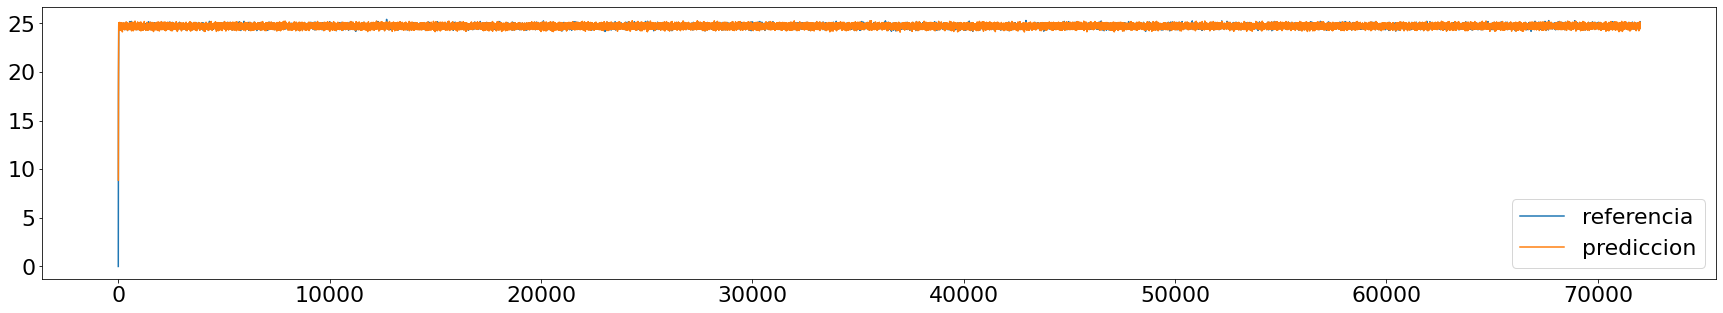

In [227]:
#plot the prediction and referencia
plt.figure(figsize=(30,5))
plt.plot(df['tiempo'][step:], df['hc'][step:], label='referencia')
plt.plot(df['tiempo'][step:], y_hat, label='prediccion')
plt.legend()

#TODO SATMODELS ARMODEL
#V. EXOGENAS.


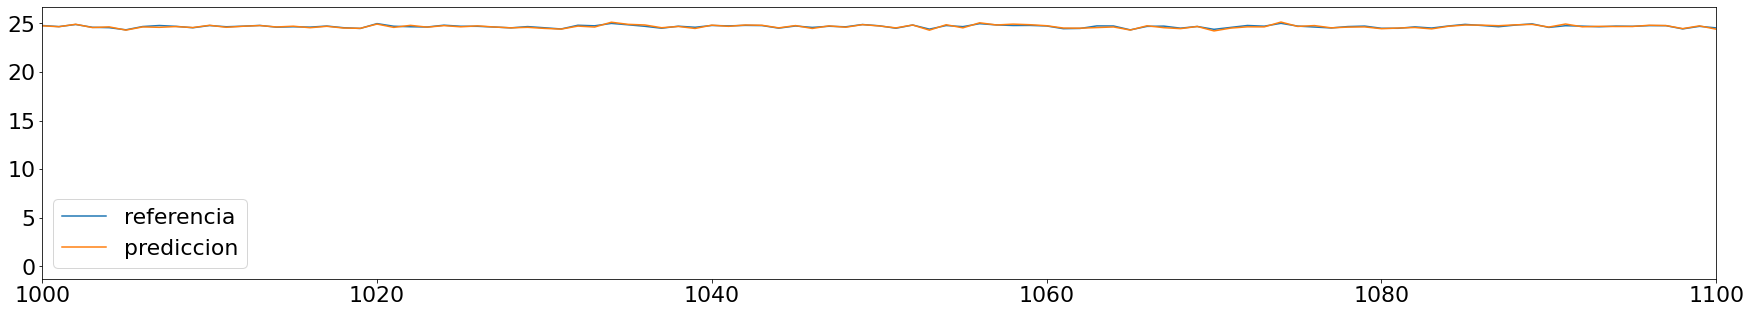

In [228]:
#snapshot of the interval [1000-1100]
plt.figure(figsize=(30,5))
plt.plot(df['tiempo'][step:], df['hc'][step:], label='referencia')
plt.plot(df['tiempo'][step:], y_hat, label='prediccion')
plt.xlim(1000, 1100)
plt.legend()


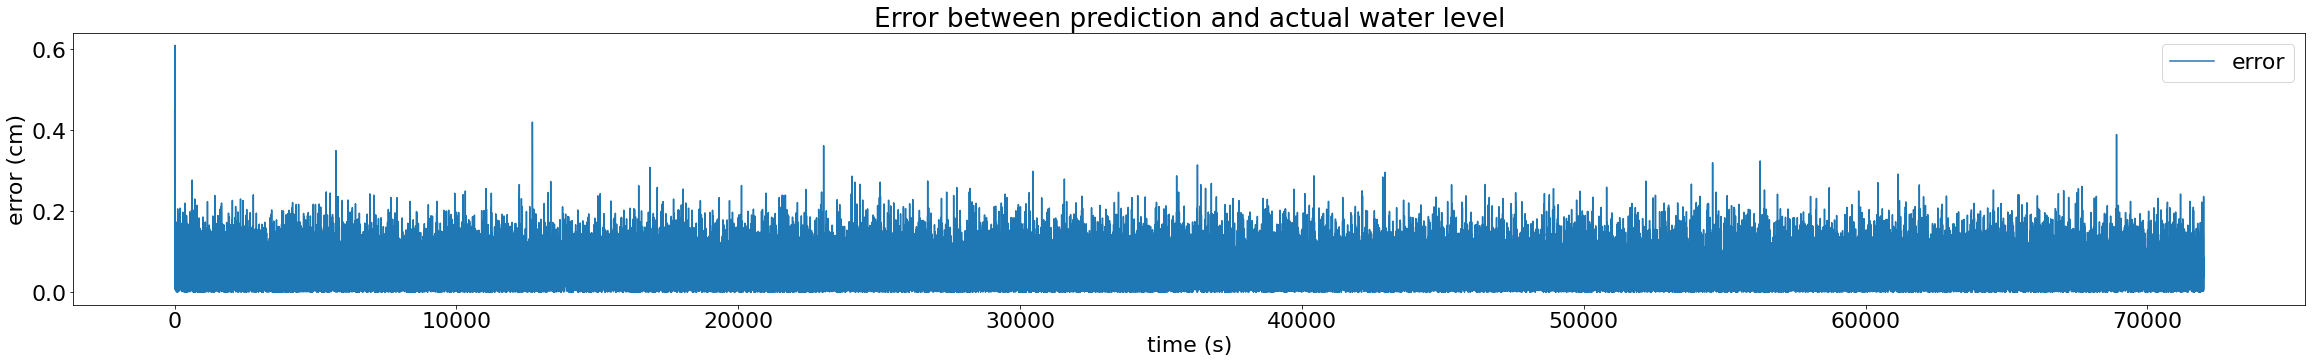

In [229]:
#plot error between prediction and actual hc
plt.figure(figsize=(40,5))
plt.plot(df['tiempo'][step:], abs(y_hat - df['hc'][step:]), label='error')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('error (cm)')
plt.title('Error between prediction and actual water level')
plt.show()


# TESTEO EN FALLA

In [230]:
model = MLP()
model.load_state_dict(torch.load('../modelos torch/model_tanque_referencia_fija_5s.pt'))
model.to(device)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=150, bias=True)
    (5): ReLU()
    (6): Linear(in_features=150, out_features=50, bias=True)
    (7): ReLU()
    (8): Linear(in_features=50, out_features=10, bias=True)
    (9): ReLU()
    (10): Linear(in_features=10, out_features=1, bias=True)
    (11): ReLU()
  )
)

In [232]:
#test with another set of data

failure_location = "bomba"
data_version = "_referencia_fija_5s"

# df_2 = pd.read_csv('../datos estanque/datos con falla/referencia_fija_falla_bomba_v2.csv') #pd.read_csv(f'../datos estanque/datos con falla/data_falla_incipiente_{failure_location}{data_version}.csv')
df_2 = pd.read_csv('../datos estanque/datos sin falla/referencia_fija_t_continuo_v2.csv') #pd.read_csv(f'../datos estanque/datos con falla/data_falla_incipiente_{failure_location}{data_version}.csv')



#create df_test sampling every 1 seconds (or trained MPL model sampling time):

df_test = df_2.iloc[::1].copy()
df_test.head()


,tiempo,referencia,hc,f_pid
0,0,25,0.000001,0.01
1,1,25,6.230122,99.99
2,2,25,9.322159,99.99
3,3,25,11.255697,99.99
4,4,25,13.107113,99.99


In [233]:
#create hc_prev same as previous

#create a new column with the previous value of hc
df_test['hc_prev'] = df_test['hc'].shift(1)

df_test['hc_prev_prev'] = df_test['hc_prev'].shift(1)
df_test['hc_prev_3'] = df_test['hc_prev_prev'].shift(1)
df_test['hc_prev_4'] = df_test['hc_prev_3'].shift(1)


df_test['freq_prev'] = df_test['f_pid'].shift(1)
df_test['freq_prev_prev'] = df_test['freq_prev'].shift(1)
df_test['freq_prev_3'] = df_test['freq_prev_prev'].shift(1)
df_test['freq_prev_4'] = df_test['freq_prev_3'].shift(1)

In [234]:
#create X_test_1 and y_test_1:
X_test_1 = torch.from_numpy(np.vstack(((df_test['hc_prev'].to_numpy(),
                                     df_test['hc_prev_prev'].to_numpy(),
                                     
                                     df_test['f_pid'].to_numpy(),
                                     df_test['freq_prev'].to_numpy(),
                                     ))).T).float()

X_test_1 = X_test_1.to(device)

y_test_1 = torch.from_numpy(((df_test['hc'].to_numpy()))).float()
y_test_1 = y_test_1.to(device)


In [235]:
#create y_hat
y_hat = model(X_test_1)
y_hat = y_hat.cpu()
y_hat = y_hat.detach().numpy()
y_hat = y_hat.flatten()


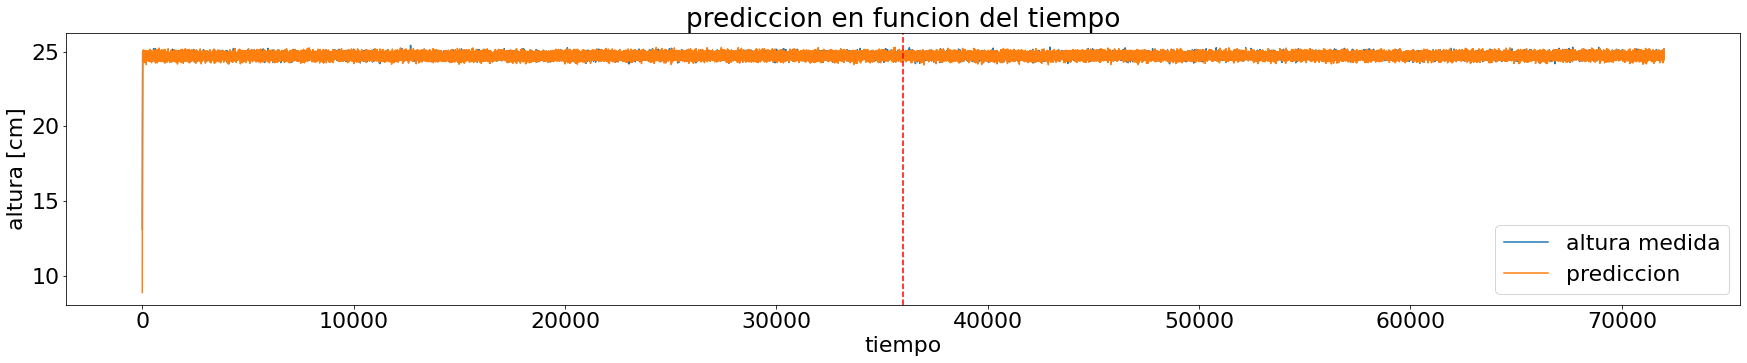

In [236]:
#plot prediction and reference
plt.figure(figsize=(30,5))
plt.plot(df_test['tiempo'][4:], df_test['hc'][4:], label='altura medida')
plt.plot(df_test['tiempo'], y_hat, label='prediccion')
# plt.plot(df_test['tiempo'][4:], df_test['f_pid'][4:])
plt.legend()
plt.xlabel('tiempo')
plt.ylabel('altura [cm]')
plt.title('prediccion en funcion del tiempo')
plt.legend()
#draw vertical line in x = 3600
plt.axvline(x=36000, color='red', linestyle='--')

plt.show()


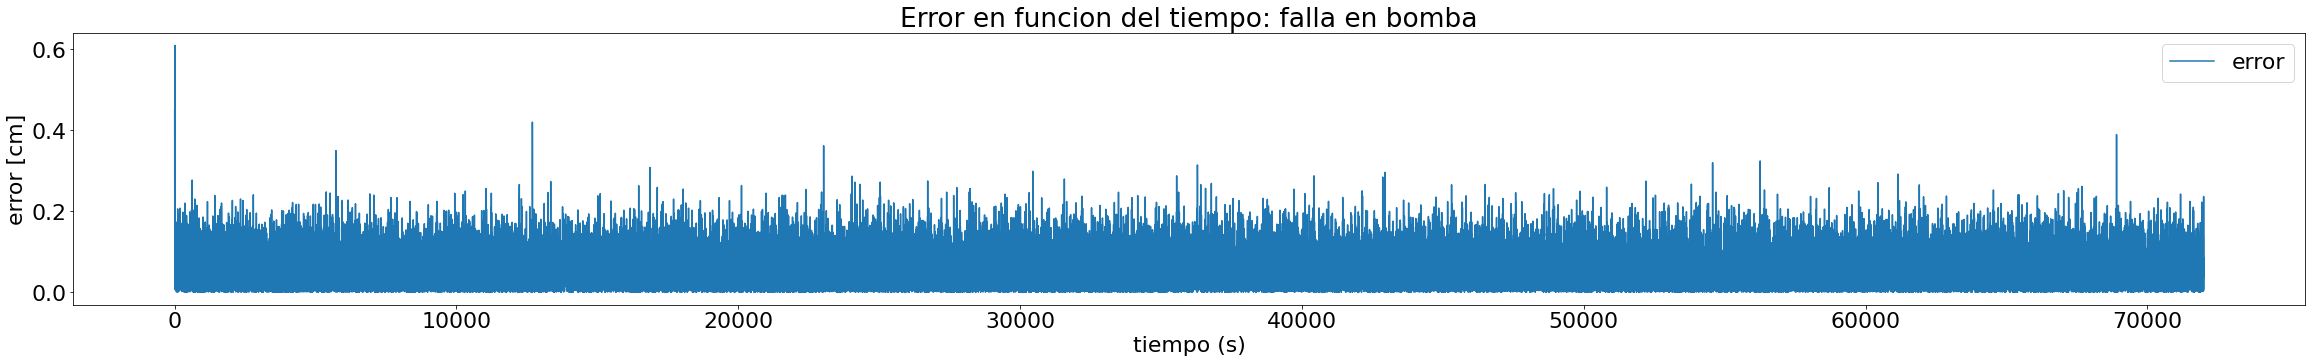

In [238]:
#plot error between prediction and reference
plt.figure(figsize=(40,5))
plt.plot(df_test['tiempo'], abs(y_hat - df_test['hc']), label='error')
plt.xlabel('tiempo (s)')
plt.ylabel('error [cm]')
plt.title(f'Error en funcion del tiempo: falla en {failure_location}')
# # draw vertical line in x = 3600 and 7200
# plt.axvline(x=36000, color='green', linestyle='--', label='inicio falla')
# plt.axvline(x=36000+3600, color='blue', linestyle='--', label='falla a 1 hora')
# plt.axvline(x=36000+2*3600, color='orange', linestyle='--', label='falla a 2 horas')
# plt.axvline(x=36000+5*3600, color='red', linestyle='--', label='falla a 5 horas')
plt.legend()

plt.show()

In [212]:

#add y_hat_1 to df_test
df_test['y_hat_1'] = y_hat
df_test['error'] =  (df_test['hc'] - df_test['y_hat_1'])

#export df_test to csv
df_test.to_csv('..\outputs modelo\csv\out_sin_falla_5s.csv')#f'..\outputs modelo\csv\out_falla_{failure_location}{data_version}.csv', index=False)

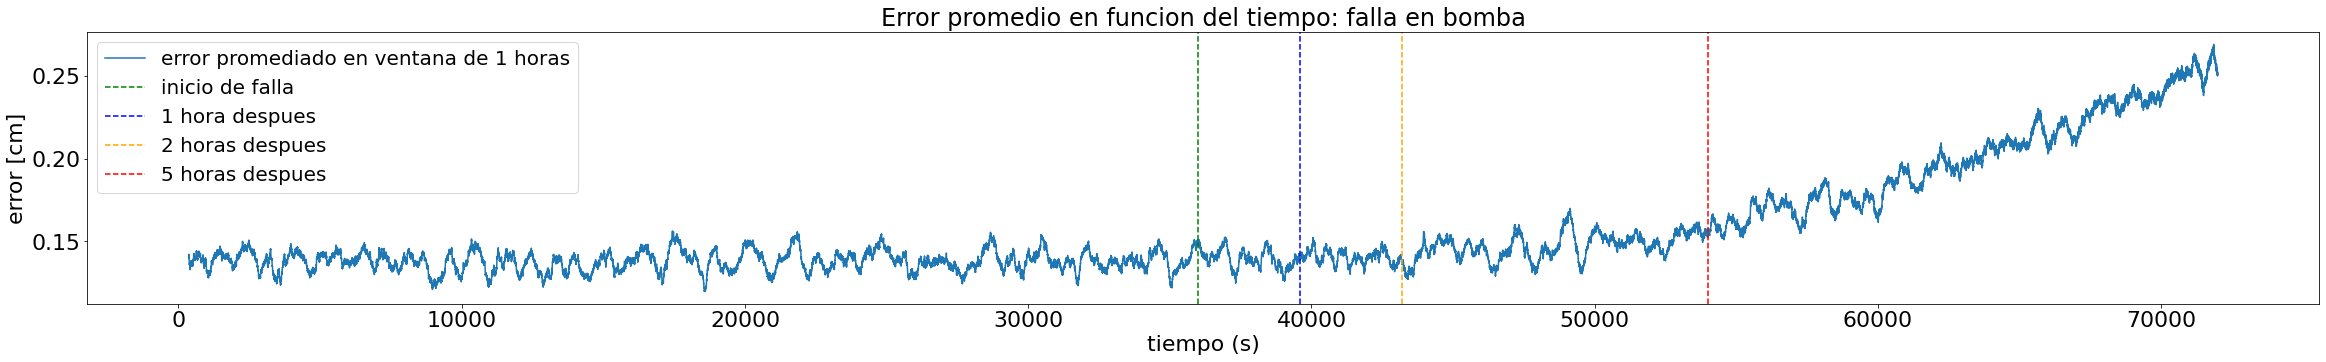

In [204]:
#plot mean error in a window of H hours sampling time

H = 1 #hours

plt.figure(figsize=(40,5))
# plt.plot(df_test['tiempo'], df_test['y_hat_1'] - df_test['hc'], label='error')
plt.plot(df_test['tiempo'],(abs(df_test['y_hat_1'] - df_test['hc'])).rolling(int(3600/10*H)).mean(), label=f'error promediado en ventana de {H} horas')
plt.rcParams.update({'font.size': 20})
plt.legend()
plt.xlabel('tiempo (s)')
plt.ylabel('error [cm]')
plt.title(f'Error promedio en funcion del tiempo: falla en {failure_location}')
# draw vertical line in x = 3600 and 7200
plt.axvline(x=36000, color='green', linestyle='--', label='inicio de falla')
plt.axvline(x=36000+3600, color='blue', linestyle='--', label='1 hora despues')
plt.axvline(x=36000+2*3600, color='orange', linestyle='--', label='2 horas despues')
plt.axvline(x=36000+5*3600, color='red', linestyle='--', label='5 horas despues')
plt.legend()
plt.show()


In [130]:
#save every column of df_test to numpy array
import os
failure_location = "fuga"
data_version =  "referencia_fija"
to_save = pd.read_csv(f'../outputs modelo/csv/out_falla_{failure_location}{data_version}.csv')

#create new directory to save numpy arrays
os.mkdir(f'../outputs modelo/npy/falla_{failure_location}{data_version}')

used_columns = ['tiempo', 'hc', 'f_pid', 'hc_prev', 'hc_prev_prev', 'freq_prev', 'y_hat_1', 'error']

for column in used_columns:
    np.save(f'../outputs modelo/npy/falla_{failure_location}{data_version}/{column}.npy', df_test[column].to_numpy())